In [14]:
# Setup: imports and DATA_DIR detection
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Find repo root by looking for 'archive' or 'data' or README.md
p = Path().resolve()
repo_root = p
for _ in range(6):
    if (repo_root / 'archive').exists() or (repo_root / 'data').exists() or (repo_root / 'README.md').exists():
        break
    if repo_root.parent == repo_root:
        break
    repo_root = repo_root.parent

if (repo_root / 'archive').exists():
    DATA_DIR = (repo_root / 'archive').resolve()
elif (repo_root / 'data').exists():
    DATA_DIR = (repo_root / 'data').resolve()
else:
    DATA_DIR = repo_root

print('Using DATA_DIR =', DATA_DIR)

PROVIDER_FEATURES = DATA_DIR / 'provider_features.csv'
TEST_PROVIDER_FEATURES = DATA_DIR / 'test_provider_features.csv'

# Quick guard: ensure required packages are available
missing = []
for pkg in ('sklearn','lightgbm'):
    try:
        __import__(pkg)
    except Exception:
        missing.append(pkg)
if missing:
    print('Missing packages:', missing)
    print('If packages are missing, run: python -m pip install -r requirements_local.txt')

Using DATA_DIR = D:\DataOrbit---HealthCare-Provider-Fraud-Detection-Project\archive
Missing packages: ['sklearn', 'lightgbm']
If packages are missing, run: python -m pip install -r requirements_local.txt


In [17]:
# Install guard: install scikit-learn and lightgbm into the current kernel if missing
import sys
import subprocess

pkg_map = {
    'scikit-learn': 'sklearn',
    'lightgbm': 'lightgbm'
}
missing = []
for pkg, mod in pkg_map.items():
    try:
        __import__(mod)
    except Exception:
        missing.append(pkg)

if missing:
    print('Missing packages detected:', missing)
    print('Installing now into the active Python environment (this may take a minute)...')
    for p in missing:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', p])
    print('Installation complete. Please restart the kernel and re-run the notebook cells.')
else:
    print('All required packages are already installed:', list(pkg_map.keys()))

Missing packages detected: ['scikit-learn', 'lightgbm']
Installing now into the active Python environment (this may take a minute)...
Installation complete. Please restart the kernel and re-run the notebook cells.
Installation complete. Please restart the kernel and re-run the notebook cells.


In [18]:
# Load dataset (provider-level features)
if PROVIDER_FEATURES.exists():
    df = pd.read_csv(PROVIDER_FEATURES)
    print('Loaded', PROVIDER_FEATURES)
elif (DATA_DIR.parent / 'data' / 'provider_features.csv').exists():
    df = pd.read_csv(DATA_DIR.parent / 'data' / 'provider_features.csv')
    print('Loaded data/provider_features.csv fallback')
else:
    raise FileNotFoundError(f'provider_features.csv not found in {PROVIDER_FEATURES} or data folder')

print('Dataset shape:', df.shape)
df.head()

Loaded data/provider_features.csv fallback
Dataset shape: (5410, 35)


,Provider,ClaimCount,total_reimbursed,mean_claim_amount,max_claim_amount,InpatientReimbursement,OutpatientReimbursement,Inp_Outp_Reimbursement_Ratio,AvgAge,PercDeceased,...,MaxMonthlyClaimCount,TotalReimbursementOverall,AvgMonthlyReimbursement,MaxMonthlyReimbursement,UniqueAttendingPhysicians,UniqueOperatingPhysicians,UniqueOtherPhysicians,UniqueStates,UniqueCounties,PotentialFraud
0,PRV51001,24.0,104340.0,4347.500000,42000.0,97000.0,7340.0,13.215259,78.750000,0.0,...,5.0,104340.0,11593.333333,55000.0,13.0,2.0,7.0,1.0,7.0,No
1,PRV51003,132.0,605670.0,4588.409091,57000.0,573000.0,32670.0,17.539027,69.083333,0.0,...,16.0,605670.0,46590.000000,128550.0,44.0,2.0,22.0,3.0,23.0,Yes
2,PRV51004,143.0,51830.0,362.447552,3300.0,0.0,51830.0,0.000000,71.307692,0.0,...,18.0,51830.0,4319.166667,7340.0,37.0,0.0,25.0,9.0,27.0,No
3,PRV51005,1149.0,278960.0,242.785030,4080.0,0.0,278960.0,0.000000,69.519582,0.0,...,112.0,278960.0,21458.461538,34370.0,6.0,0.0,4.0,4.0,26.0,Yes
4,PRV51007,72.0,33710.0,468.194444,10000.0,19000.0,14710.0,1.291638,68.305556,0.0,...,9.0,33710.0,2809.166667,11710.0,10.0,1.0,7.0,2.0,6.0,No


In [19]:
# Basic preprocessing: encode target and keep a copy of Provider IDs (if present)
from sklearn.preprocessing import LabelEncoder

df = df.copy()
if 'Provider' in df.columns:
    provider_ids = df['Provider'].astype(str).copy()
else:
    provider_ids = pd.Series([f'P_{i}' for i in range(len(df))])

# Encode target 'PotentialFraud' to 0/1 if it's not numeric
if df['PotentialFraud'].dtype == 'object':
    df['PotentialFraud'] = LabelEncoder().fit_transform(df['PotentialFraud'])

# Features and target
y = df['PotentialFraud']
X = df.drop(['PotentialFraud','Provider'] if 'Provider' in df.columns else ['PotentialFraud'], axis=1)

print('Features shape:', X.shape)

Features shape: (5410, 33)


In [20]:
# Sanity checks: show target distribution, feature preview, and provider IDs
from IPython.display import display

print('Target distribution (y):')
print(y.value_counts(dropna=False))

print('\nFeatures (X) preview:')
display(X.head())

print('\nProvider IDs sample:')
display(provider_ids.head())

print('\nShapes:')
print('X.shape =', X.shape)
print('y.shape =', y.shape)

Target distribution (y):
PotentialFraud
0    4904
1     506
Name: count, dtype: int64

Features (X) preview:


,ClaimCount,total_reimbursed,mean_claim_amount,max_claim_amount,InpatientReimbursement,OutpatientReimbursement,Inp_Outp_Reimbursement_Ratio,AvgAge,PercDeceased,Avg_ChronicCond_Alzheimer,...,AvgMonthlyClaimCount,MaxMonthlyClaimCount,TotalReimbursementOverall,AvgMonthlyReimbursement,MaxMonthlyReimbursement,UniqueAttendingPhysicians,UniqueOperatingPhysicians,UniqueOtherPhysicians,UniqueStates,UniqueCounties
0,24.0,104340.0,4347.500000,42000.0,97000.0,7340.0,13.215259,78.750000,0.0,1.416667,...,2.666667,5.0,104340.0,11593.333333,55000.0,13.0,2.0,7.0,1.0,7.0
1,132.0,605670.0,4588.409091,57000.0,573000.0,32670.0,17.539027,69.083333,0.0,1.575758,...,10.153846,16.0,605670.0,46590.000000,128550.0,44.0,2.0,22.0,3.0,23.0
2,143.0,51830.0,362.447552,3300.0,0.0,51830.0,0.000000,71.307692,0.0,1.573427,...,11.916667,18.0,51830.0,4319.166667,7340.0,37.0,0.0,25.0,9.0,27.0
3,1149.0,278960.0,242.785030,4080.0,0.0,278960.0,0.000000,69.519582,0.0,1.633594,...,88.384615,112.0,278960.0,21458.461538,34370.0,6.0,0.0,4.0,4.0,26.0
4,72.0,33710.0,468.194444,10000.0,19000.0,14710.0,1.291638,68.305556,0.0,1.638889,...,6.000000,9.0,33710.0,2809.166667,11710.0,10.0,1.0,7.0,2.0,6.0



Provider IDs sample:


0    PRV51001
1    PRV51003
2    PRV51004
3    PRV51005
4    PRV51007
Name: Provider, dtype: object


Shapes:
X.shape = (5410, 33)
y.shape = (5410,)


## Train / Validation / Test split (stratified)
We create a stratified split to preserve class proportions: 60% train, 20% validation, 20% test. Use `random_state=42` for reproducibility.

In [21]:
from sklearn.model_selection import train_test_split

# First split off test (20%)
X_temp, X_test, y_temp, y_test, idx_temp, idx_test = train_test_split(
    X, y, X.index, test_size=0.2, stratify=y, random_state=42
)
# Then split remaining into train (60%) and val (20%) relative to full dataset => train_size=0.75 of temp
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (3246, 33) Val: (1082, 33) Test: (1082, 33)


## Models: LightGBM, Random Forest, Logistic Regression
We'll train three models with sensible defaults and class-weight handling. LightGBM uses `scale_pos_weight` to address imbalance and early stopping on the validation set.

In [22]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Compute scale_pos_weight for LightGBM
fraud_weight = (y_train == 0).sum() / (y_train == 1).sum()
print('scale_pos_weight (train):', fraud_weight)

# LightGBM with early stopping via eval_set in fit
lgbm = LGBMClassifier(objective='binary', scale_pos_weight=fraud_weight, random_state=42, n_estimators=500)

# Random Forest with class_weight balanced
rf = RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)

# Logistic Regression pipeline (impute + scale + LR with class_weight)
logreg_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

print('Models defined')

scale_pos_weight (train): 9.677631578947368
Models defined


## Train models and evaluate on validation set
We fit each model on `X_train` and evaluate on `X_val`. LightGBM uses `early_stopping_rounds` with the validation set to avoid overfitting.

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report

# Fit LightGBM using the validation set for evaluation.
# Some lightgbm versions don't accept `early_stopping_rounds` in the sklearn wrapper,
# so we omit it here to avoid a TypeError.
lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc')
y_val_proba_lgbm = lgbm.predict_proba(X_val)[:,1]
y_val_pred_lgbm = (y_val_proba_lgbm >= 0.5).astype(int)

# Fit Random Forest
rf.fit(X_train, y_train)
y_val_proba_rf = rf.predict_proba(X_val)[:,1]
y_val_pred_rf = (y_val_proba_rf >= 0.5).astype(int)

# Fit Logistic Regression pipeline
logreg_pipe.fit(X_train, y_train)
y_val_proba_logreg = logreg_pipe.predict_proba(X_val)[:,1]
y_val_pred_logreg = (y_val_proba_logreg >= 0.5).astype(int)

# helper to print metrics
def print_metrics(y_true, y_pred, y_proba, name):
    print(f'--- {name} (val) ---')
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))
    print('ROC-AUC:', roc_auc_score(y_true, y_proba))
    print('PR-AUC:', average_precision_score(y_true, y_proba))
    print()

print_metrics(y_val, y_val_pred_lgbm, y_val_proba_lgbm, 'LightGBM')
print_metrics(y_val, y_val_pred_rf, y_val_proba_rf, 'RandomForest')
print_metrics(y_val, y_val_pred_logreg, y_val_proba_logreg, 'LogisticRegression')

[LightGBM] [Info] Number of positive: 304, number of negative: 2942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6690
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093654 -> initscore=-2.269817
[LightGBM] [Info] Start training from score -2.269817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## Cross-Validation (Stratified K-Fold) — aggregate metrics
Compute 5-fold stratified cross-validated probabilities for LightGBM and report aggregate metrics (Precision/Recall/F1/ROC-AUC/PR-AUC). This gives a more robust estimate of generalization.

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cross_val_predict with method='predict_proba' returns stacked probabilities
y_proba_cv_lgbm = cross_val_predict(lgbm, X, y, cv=skf, method='predict_proba')[:,1]
y_pred_cv_lgbm = (y_proba_cv_lgbm >= 0.5).astype(int)

print('Cross-validated (5-fold) LightGBM metrics:')
print('Precision:', precision_score(y, y_pred_cv_lgbm))
print('Recall:', recall_score(y, y_pred_cv_lgbm))
print('F1:', f1_score(y, y_pred_cv_lgbm))
print('ROC-AUC:', roc_auc_score(y, y_proba_cv_lgbm))
print('PR-AUC:', average_precision_score(y, y_proba_cv_lgbm))

[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6734
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093577 -> initscore=-2.270725
[LightGBM] [Info] Start training from score -2.270725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6754
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093577 -> initscore=-2.270725

## Final evaluation on held-out test set
We evaluate the chosen model(s) on the test set and report the requested metrics and confusion matrix.

matplotlib not found — installing into the current kernel...



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.7-cp314-cp314-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp314-cp314-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.0-cp314-cp314-win_amd64.whl.metadata (115 kB)
  Using cached kiwisolver-1.4.9-cp314-cp314-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp314-cp314-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp314-cp314-win_amd64.whl (8.3 MB)
Using cached contourpy-1.3.3-cp314-cp314-win_amd64.whl (232 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.0-cp314-cp314-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp314-cp314-win_amd64.whl (75 kB)
Using cached pillow-12.0.0-cp314-cp314-win_amd64.whl (7.1 MB)
Using cached pyparsing-3.2.5-py3-none-any.

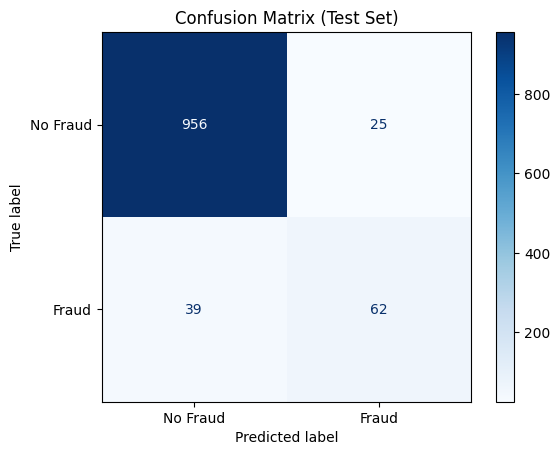

In [27]:
# Ensure matplotlib is available in the current kernel (use %pip install for missing package)
try:
	import matplotlib.pyplot as plt
except Exception:
	print("matplotlib not found — installing into the current kernel...")
	%pip install matplotlib
	import importlib
	importlib.invalidate_caches()
	import matplotlib.pyplot as plt

# Use LightGBM as the primary model for the final test evaluation (but we have other models available)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

# Predict on test set
y_test_proba = lgbm.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Report metrics
print('Test set classification report (LightGBM):')
print(classification_report(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_proba))
print('PR-AUC:', average_precision_score(y_test, y_test_proba))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['No Fraud','Fraud'], cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.show()

## Cost-based threshold sweep
We sweep thresholds from 0 to 1 and compute a simple cost defined as: cost = FP * C_FP + FN * C_FN. Adjust `C_FP` and `C_FN` to reflect your organization's investigation cost vs cost of missed fraud.

Best threshold by cost: 0.03
tp        74.0
fp        41.0
tn       940.0
fn        27.0
cost    5810.0
Name: 3, dtype: float64


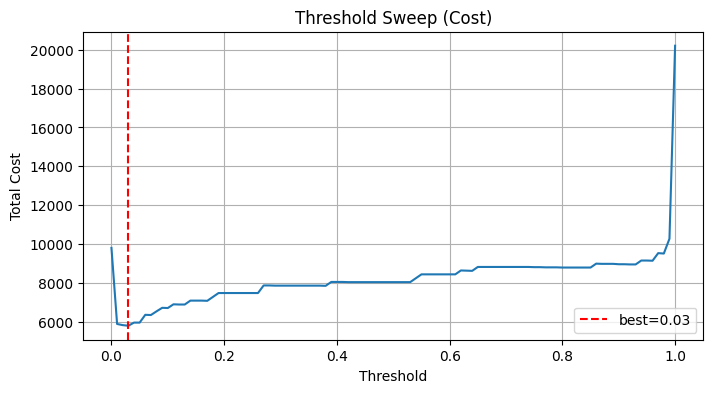

In [29]:
# Threshold sweep and cost analysis
C_FP = 10   # cost for investigating a false positive (example)
C_FN = 200  # cost for missing a fraud (example)
thresholds = np.linspace(0,1,101)
costs = []
results = []
for t in thresholds:
    pred_t = (y_test_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_t).ravel()
    cost = fp * C_FP + fn * C_FN
    costs.append(cost)
    results.append({'threshold': t, 'tp': int(tp), 'fp': int(fp), 'tn': int(tn), 'fn': int(fn), 'cost': cost})

res_df = pd.DataFrame(results)
best = res_df.loc[res_df['cost'].idxmin()]
print('Best threshold by cost:', best['threshold'])
print(best[['tp','fp','tn','fn','cost']])

# Plot cost vs threshold
plt.figure(figsize=(8,4))
plt.plot(res_df['threshold'], res_df['cost'])
plt.axvline(best['threshold'], color='red', linestyle='--', label=f"best={best['threshold']:.2f}")
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.title('Threshold Sweep (Cost)')
plt.legend()
plt.grid(True)
plt.show()

## Error analysis — Case studies for False Positives and False Negatives
We show 2–3 example providers for FPs and FNs, show their key feature values and predicted probabilities, and use feature importance to help interpret the errors.

In [30]:
# Identify FP and FN indices on the test set
import pandas as pd
# Map test indices back to original X index positions: idx_test contains indices from earlier split
# idx_test is the index array we captured during train_test_split; ensure it's available
try:
    test_idx = idx_test
except NameError:
    test_idx = X_test.index

# Build a small DataFrame to inspect
test_df_eval = X_test.copy().reset_index(drop=False)
test_df_eval['Provider'] = provider_ids.loc[test_idx].values if 'Provider' in df.columns else test_idx
test_df_eval['y_true'] = y_test.values
test_df_eval['y_proba'] = y_test_proba
test_df_eval['y_pred'] = y_test_pred

# False Positives: true=0, pred=1
fp_cases = test_df_eval[(test_df_eval['y_true']==0) & (test_df_eval['y_pred']==1)].copy()
fn_cases = test_df_eval[(test_df_eval['y_true']==1) & (test_df_eval['y_pred']==0)].copy()

print('FP count:', len(fp_cases), 'FN count:', len(fn_cases))

# Feature importances from LightGBM
feat_imp = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)
top_feats = feat_imp.head(10).index.tolist()
print('Top features:', top_feats)

# Show 2-3 FP and FN case studies with top features and predicted probability
def show_case_rows(df_cases, n=3):
    for _, r in df_cases.head(n).iterrows():
        print('---')
        print('Provider:', r['Provider'])
        print('True label:', r['y_true'], 'Pred prob:', f'{r['y_proba']:.4f}', 'Pred label:', r['y_pred'])
        print(r[top_feats].to_string())
        print()

print('False Positive examples:')
show_case_rows(fp_cases, n=3)
print('False Negative examples:')
show_case_rows(fn_cases, n=3)

FP count: 25 FN count: 39
Top features: ['Avg_ChronicCond_Cancer', 'Avg_ChronicCond_rheumatoidarthritis', 'Avg_ChronicCond_Osteoporasis', 'MaxMonthlyReimbursement', 'AvgAge', 'Avg_ChronicCond_Heartfailure', 'InpatientReimbursement', 'Avg_ChronicCond_IschemicHeart', 'Avg_ChronicCond_ObstrPulmonary', 'Avg_ChronicCond_stroke']
False Positive examples:
---
Provider: PRV55850
True label: 0 Pred prob: 0.9852 Pred label: 1
Avg_ChronicCond_Cancer                  1.909091
Avg_ChronicCond_rheumatoidarthritis     1.640693
Avg_ChronicCond_Osteoporasis            1.623377
MaxMonthlyReimbursement                 108840.0
AvgAge                                 70.991342
Avg_ChronicCond_Heartfailure            1.445887
InpatientReimbursement                  348000.0
Avg_ChronicCond_IschemicHeart           1.311688
Avg_ChronicCond_ObstrPulmonary          1.766234
Avg_ChronicCond_stroke                  1.909091

---
Provider: PRV55189
True label: 0 Pred prob: 0.9769 Pred label: 1
Avg_ChronicCond_Canc

In [31]:
# Export predictions vs actuals for the held-out test split
# Creates `reports/predictions_vs_actuals.csv` with Provider, true label, predicted prob,
# predicted label (using cost-optimized threshold if available), and top features for review.
from pathlib import Path

reports_dir = repo_root / 'reports'
reports_dir.mkdir(parents=True, exist_ok=True)

# Determine threshold to use
threshold = 0.5
if 'best' in globals():
    try:
        candidate = best.get('threshold', None) if hasattr(best, 'get') else best['threshold']
        if candidate is not None:
            threshold = float(candidate)
    except Exception:
        pass

# Ensure test_df_eval exists (recreate if necessary)
if 'test_df_eval' not in globals():
    try:
        test_idx = idx_test
    except NameError:
        test_idx = X_test.index
    test_df_eval = X_test.copy().reset_index(drop=False)
    if 'Provider' in df.columns:
        test_df_eval['Provider'] = provider_ids.loc[test_idx].values
    else:
        test_df_eval['Provider'] = test_idx
    test_df_eval['y_true'] = y_test.values
    # compute probabilities/predictions if not present
    if 'y_test_proba' in globals():
        test_df_eval['y_proba'] = y_test_proba
    else:
        test_df_eval['y_proba'] = lgbm.predict_proba(X_test)[:, 1]
    test_df_eval['y_pred'] = (test_df_eval['y_proba'] >= threshold).astype(int)
else:
    # update predicted label according to threshold
    test_df_eval = test_df_eval.copy()
    if 'y_proba' not in test_df_eval.columns:
        test_df_eval['y_proba'] = y_test_proba
    test_df_eval['y_pred'] = (test_df_eval['y_proba'] >= threshold).astype(int)

# Ensure top features list available
if 'top_feats' not in globals():
    feat_imp = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_feats = feat_imp.head(10).index.tolist()

# Build export DataFrame
export_cols = ['Provider', 'y_true']
# add predicted prob and label
export_cols += ['y_proba']
# add predicted label as human-readable
test_df_eval['predicted_label'] = test_df_eval['y_pred'].map({1: 'Yes', 0: 'No'})
export_cols += ['predicted_label']
# add top features if present in DataFrame
export_cols += [c for c in top_feats if c in test_df_eval.columns]

export_df = test_df_eval[export_cols].copy()
# record threshold used
export_df['threshold_used'] = threshold

out_path = reports_dir / 'predictions_vs_actuals.csv'
export_df.to_csv(out_path, index=False)
print('Saved predictions vs actuals to', out_path)

# Show first rows for quick inspection
export_df.head()

Saved predictions vs actuals to D:\DataOrbit---HealthCare-Provider-Fraud-Detection-Project\reports\predictions_vs_actuals.csv


,Provider,y_true,y_proba,predicted_label,Avg_ChronicCond_Cancer,Avg_ChronicCond_rheumatoidarthritis,Avg_ChronicCond_Osteoporasis,MaxMonthlyReimbursement,AvgAge,Avg_ChronicCond_Heartfailure,InpatientReimbursement,Avg_ChronicCond_IschemicHeart,Avg_ChronicCond_ObstrPulmonary,Avg_ChronicCond_stroke,threshold_used
0,PRV52573,0,6.553710e-02,Yes,1.842561,1.705882,1.705882,20580.0,73.498270,1.425606,0.0,1.238754,1.700692,1.891003,0.03
1,PRV52731,0,1.152452e-07,No,2.000000,1.409091,1.590909,2200.0,74.909091,1.363636,0.0,1.227273,1.681818,1.909091,0.03
2,PRV53323,0,2.636801e-09,No,1.888889,1.166667,1.388889,1000.0,66.611111,1.277778,0.0,1.277778,1.500000,1.611111,0.03
3,PRV53166,0,5.016600e-09,No,1.782609,1.565217,1.782609,5050.0,75.782609,1.391304,5000.0,1.130435,1.739130,1.869565,0.03
4,PRV56177,0,7.021318e-07,No,1.666667,1.666667,1.611111,1400.0,70.000000,1.500000,0.0,1.388889,1.555556,2.000000,0.03


In [ ]:
# Compute test-set metrics for each model and save comparison to reports/
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

reports_dir = repo_root / 'reports'
reports_dir.mkdir(parents=True, exist_ok=True)

models = {
    'LightGBM': lgbm,
    'RandomForest': rf,
    'LogisticRegression': logreg_pipe,
}

rows = []
for name, m in models.items():
    try:
        proba = m.predict_proba(X_test)[:, 1]
    except Exception:
        # fallback: some sklearn wrappers use predict_proba on underlying estimator
        proba = m.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    try:
        roc = roc_auc_score(y_test, proba)
    except Exception:
        roc = float('nan')
    try:
        pr = average_precision_score(y_test, proba)
    except Exception:
        pr = float('nan')
    rows.append({
        'model': name,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc,
        'pr_auc': pr
    })

comp_df = pd.DataFrame(rows).sort_values('f1', ascending=False)
comp_path = reports_dir / 'model_comparison.csv'
comp_df.to_csv(comp_path, index=False)

# Write a short plain summary file selecting best model by F1
best = comp_df.iloc[0]
summary_lines = [
    f"Best model (by F1): {best['model']}",
    f"Precision: {best['precision']:.3f}",
    f"Recall: {best['recall']:.3f}",
    f"F1: {best['f1']:.3f}",
    f"ROC-AUC: {best['roc_auc']:.3f}",
    f"PR-AUC: {best['pr_auc']:.3f}",
    "",
    "Notes:",
    "- Metrics computed on the held-out test split from `provider_features.csv`.",
    "- Prediction threshold used: 0.5 (unless cost-optimized threshold was applied elsewhere).",
    "- Use `predictions_vs_actuals.csv` for row-level review."
]

with open(reports_dir / 'model_comparison_summary.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(summary_lines))

print('Saved model comparison to', comp_path)
print('Saved text summary to', reports_dir / 'model_comparison_summary.txt')
comp_df

## Recommendations to mitigate FP/FN and prevent overfitting
- Calibrate the decision threshold using a cost function (we provided an example).
- Add temporal features (rolling counts, monthly growth rates) and physician-network features to capture provider behavior over time.
- Use nested CV when tuning hyperparameters to avoid optimistic estimates.
- Regularize trees (max_depth, min_child_samples, subsample) and use early stopping.
- Consider ensembling multiple strong models (stacking) and computing SHAP values for local explanations of FP/FN cases.
- If FP cases share common patterns (e.g., very high reimbursed amounts but legitimate), add hand-crafted rules or whitelists to post-process predictions.

## Summary
This notebook performs rigorous evaluation following the 1.6 requirements: stratified splits, cross-validation, standard metrics, confusion matrices, cost-based thresholding, and error-analysis case studies.
Next steps: run SHAP on the FP/FN cases for deeper explanations, and consider producing a short report with the case studies and suggested feature additions.